In [1]:
# Install and import the necessary libraries
!pip install -q -U torch
!pip install -q -U accelerate peft bitsandbytes transformers trl einops evaluate
!pip install -q -U tqdm
# !pip install -q -U git+https://github.com/sissa-data-science/DADApy
!pip install scikit-dimension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import torch
from datasets import load_dataset
from datasets import load_from_disk
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
    logging,
    DistilBertModel,
    DistilBertTokenizer,
)
from tqdm import tqdm
from trl import SFTTrainer
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
# from dadapy.data import Data
import numpy as np
import skdim

2024-06-20 15:48:51.987737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 15:48:51.987856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 15:48:52.113535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Model
base_model = "microsoft/phi-2"

# Dataset
dataset = load_dataset("prsdm/MedQuad-phi2-1k", split="train")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side="right"

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        ).to("cuda")
    return encoded

In [5]:
# Applying tokenization to the dataset
tokenized_dataset = dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["text"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [6]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map={"": 0},
)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Individual ID Estimator Estimation

In [ ]:
import torch
import gc
from tqdm import tqdm
import skdim

# Constants
torch.cuda.empty_cache()
gc.collect()
num_data = 200
per_batch = 25
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        hidden_layers.append(liste)
        del outputs, liste, inputs
        torch.cuda.empty_cache()
        gc.collect()

# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []
n = len(hidden_layers[0])
for j in range(n):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)

# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

del hidden_layers, hidden_layers_avg
gc.collect()

# Compute intrinsic dimensions
intrinsic_dims = []
for i in range(n):
    X = hidden_layers_stacked[i].numpy()

    # Example using TwoNN ID Estimator
#     nn_estimator = skdim.id.TwoNN()
#     id_estimate = nn_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # 2NN ID Estimator
#     data = Data(X)
#     data.remove_identical_points()
#     id_list_2NN,_, _ = data.return_id_scaling_2NN() 
#     intrinsic_dims.append(id_list_2NN[1])

    # KNN ID Estimator
#     knn_estimator = skdim.id.KNN()
#     id_estimate = knn_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # MLE ID Estimator
#     mle_estimator = skdim.id.MLE()
#     id_estimate = mle_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # ESS ID Estimator
#     ess_estimator = skdim.id.ESS()
#     id_estimate = ess_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # PCA
    pca_estimator = skdim.id.lPCA()
    id_estimate = pca_estimator.fit_transform(X)
    intrinsic_dims.append(id_estimate)

    # FisherS ID Estimator
#     fisherS_estimator = skdim.id.FisherS()
#     id_estimate = fisherS_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # Correlation Dimension ID Estimator
#     corrInt_estimator = skdim.id.CorrInt()
#     id_estimate = corrInt_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # TLE ID Estimator
#     tle_estimator = skdim.id.TLE()
#     id_estimate = tle_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

In [9]:
for i in range(len(intrinsic_dims)):
    intrinsic_dims[i] = round(intrinsic_dims[i], 2)
print(intrinsic_dims)

[23, 26, 17, 12, 13, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 20, 17, 19, 15]


In [10]:
id_knn = [6, 2560, 2560, 3, 3, 31, 2560, 190, 3, 2, 2560, 3, 2560, 2, 2, 2, 3, 29, 8, 3, 73, 2560, 4, 2560, 2, 2560, 2560, 2560, 2, 18, 2560, 10, 7]
id_mle = [12.77, 12.37, 11.95, 11.37, 11.12, 10.96, 10.58, 10.28, 10.17, 10.3, 10.22, 10.16, 10.15, 10.08, 9.9, 9.81, 9.91, 9.71, 9.71, 9.69, 9.74, 9.71, 9.68, 9.66, 9.73, 9.7, 9.56, 9.67, 9.92, 10.16, 9.9, 9.76, 10.07]
id_2NN = [14.94, 15.68, 16.18, 16.07, 15.52, 15.04, 13.61, 12.86, 12.21, 12.0, 12.07, 12.54, 13.01, 13.27, 13.54, 13.49, 13.74, 13.93, 14.1, 13.86, 12.79, 12.4, 11.72, 10.94, 10.27, 9.29, 9.23, 9.24, 9.3, 10.31, 10.58, 10.93, 9.33] 
id_fs = [4.66, 4.58, 3.76, 3.53, 3.5, 3.64, 3.66, 3.66, 3.66, 3.6, 3.62, 3.64, 3.73, 3.71, 3.68, 3.67, 3.66, 3.65, 3.58, 3.58, 3.56, 3.54, 3.54, 3.58, 3.62, 3.67, 3.68, 3.67, 3.68, 4.21, 4.07, 4.11, 3.65]
id_corrInt = [5.77, 5.39, 5.04, 4.88, 4.35, 4.13, 4.17, 4.27, 4.08, 3.86, 3.65, 3.78, 3.64, 3.57, 3.46, 3.37, 3.25, 3.31, 3.26, 3.34, 3.49, 3.64, 3.71, 4.36, 4.47, 4.05, 3.79, 3.55, 3.38, 3.2, 3.39, 3.29, 3.43] 
id_tle = [10.86, 10.4, 10.1, 9.66, 9.45, 9.32, 9.05, 8.8, 8.71, 8.81, 8.74, 8.76, 8.75, 8.69, 8.53, 8.47, 8.55, 8.4, 8.36, 8.31, 8.34, 8.27, 8.28, 8.26, 8.29, 8.2, 8.08, 8.11, 8.28, 8.49, 8.36, 8.35, 8.61]
id_pca = [23, 26, 17, 12, 13, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 20, 17, 19, 15]

In [11]:
import matplotlib.pyplot as plt
import numpy as np

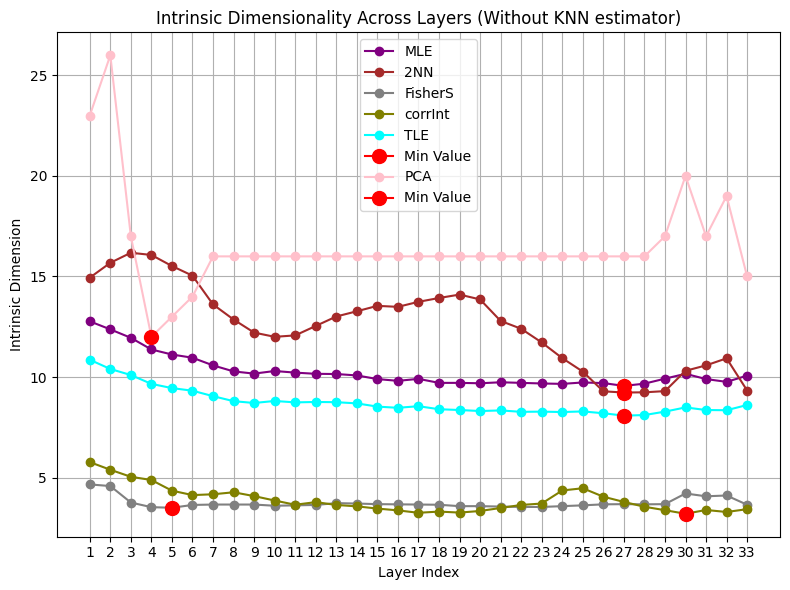

In [12]:
# Plot results
# Find the index of the minimum value
# min_index_2 = id_2nn_scale.index(min(id_2nn_scale)) + 1
min_index_3 = id_knn.index(min(id_knn)) + 1
min_index_4 = id_mle.index(min(id_mle)) + 1
min_index_5 = id_2NN.index(min(id_2NN)) + 1
# min_index_6 = mean_id_ess.index(min(id_ess)) + 1
min_index_7 = id_fs.index(min(id_fs)) + 1
min_index_8 = id_corrInt.index(min(id_corrInt)) + 1
min_index_9 = id_tle.index(min(id_tle)) + 1
min_index_10 = id_pca.index(min(id_pca)) + 1


# Plot results
plt.figure(figsize=(8, 6))

# plt.plot(np.arange(1, 34), id_2nn_scale, marker='o', linestyle='-', label='2NN scale', color='orange')
# plt.plot(min_index_2, min(id_2nn_scale), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_knn, marker='o', linestyle='-', label='KNN',color='green')
# plt.plot(min_index_3, min(id_knn), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_mle, marker='o', linestyle='-', label='MLE',color='purple')
plt.plot(min_index_4, min(id_mle), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_2NN, marker='o', linestyle='-', label='2NN',color='brown')
plt.plot(min_index_5, min(id_2NN), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_ess, marker='o', linestyle='-', label='ESS',color='pink')
# plt.plot(min_index_6, min(id_ess), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_fs, marker='o', linestyle='-', label='FisherS',color='gray')
plt.plot(min_index_7, min(id_fs), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_corrInt, marker='o', linestyle='-', label='corrInt',color='olive')
plt.plot(min_index_8, min(id_corrInt), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_tle, marker='o', linestyle='-', label='TLE',color='cyan')
plt.plot(min_index_9, min(id_tle), marker='o', color='red', markersize=10, label='Min Value')

plt.plot(np.arange(1, 34), id_pca, marker='o', linestyle='-', label='PCA',color='pink')
plt.plot(min_index_10, min(id_pca), marker='o', color='red', markersize=10, label='Min Value')

plt.title('Intrinsic Dimensionality Across Layers (Without KNN estimator)')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 34))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer.png")
plt.show()

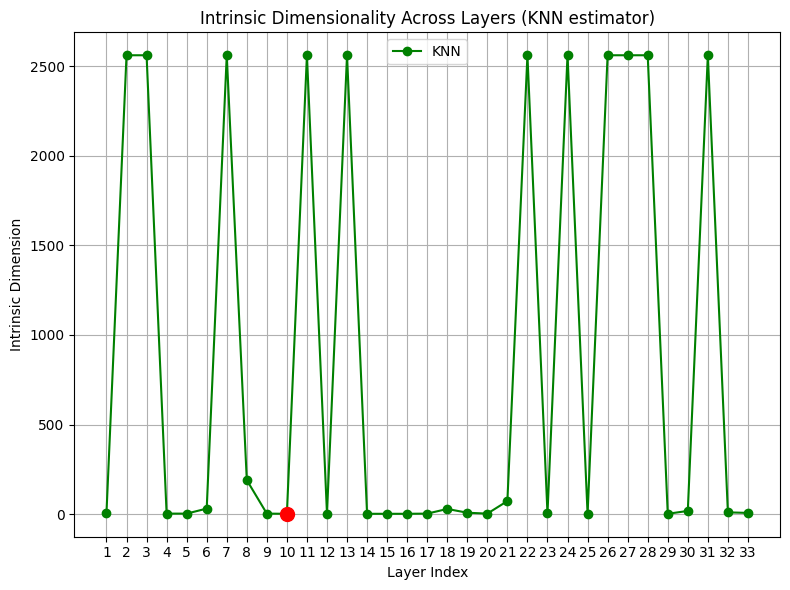

In [19]:
min_index_3 = id_knn.index(min(id_knn)) + 1

# Plot results
plt.figure(figsize=(8, 6))

plt.plot(np.arange(1, 34), id_knn, marker='o', linestyle='-', label='KNN',color='green')
plt.plot(min_index_3, min(id_knn), marker='o', color='red', markersize=10)

plt.title('Intrinsic Dimensionality Across Layers (KNN estimator)')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 34))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer.png")
plt.show()

## Persistent homology ID Calculation

In [7]:
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

In [8]:
def compute_persistent_score(embeddings):
    """
    Compute the persistent score for a subset of embeddings using the sum of edge weights in the MST.
    
    Parameters:
    - embeddings (numpy.ndarray): A matrix where each row is an embedding.
    
    Returns:
    - float: The persistent score for the embeddings.
    """
    dist_matrix = distance_matrix(embeddings, embeddings)
    mst = minimum_spanning_tree(dist_matrix)
    return mst.sum()

In [9]:
def sample_and_score(embeddings, n, k=8, hat_n=40, J=7):
    """
    For various sample sizes, compute the median persistent score across J samples.
    
    Parameters:
    - embeddings (numpy.ndarray): A matrix where each row is an embedding.
    - n (int): Total number of embeddings.
    - k (int): Number of different sample sizes.
    - hat_n (int): A parameter for determining sample sizes.
    - J (int): Number of samples for each sample size.
    
    Returns:
    - list: List of sample sizes.
    - list: List of corresponding median persistent scores.
    """
    scores = []
    sizes = [(i - 1) * (n - hat_n) // k + hat_n for i in range(1, k + 1)]
    
    for size in sizes:
        subset_scores = [compute_persistent_score(embeddings[np.random.choice(n, size, replace=False)])
                         for _ in range(J)]
        scores.append(np.median(subset_scores))
    
    return sizes, scores

In [10]:
def estimate_dimension(sizes, scores):
    """
    Estimate the intrinsic dimension of the data using linear regression on log-transformed sizes and scores.
    
    Parameters:
    - sizes (list): List of sample sizes.
    - scores (list): List of corresponding median persistent scores.
    
    Returns:
    - float: Estimated dimension of the data.
    """
    log_sizes = np.log(sizes).reshape(-1, 1)
    log_scores = np.log(scores)

    reg = LinearRegression().fit(log_sizes, log_scores)
    slope = reg.coef_[0]
    
    return 1 / (1 - slope)

In [11]:
def estimate_sequence_dimension(embeddings, runs=20):
    """
    Estimate the intrinsic dimension of the text by repeatedly sampling subsets of its tokens, 
    computing their persistent scores, and then using linear regression on the log-transformed values.
    
    Parameters:
    - text (str): The input text for which the dimension needs to be estimated.
    - runs (int): Number of runs with different random seeds.
    
    Returns:
    - float: Estimated dimension of the text.
    """
    n = embeddings.shape[0]
    
    slopes = []
    for _ in range(runs):
        sizes, scores = sample_and_score(embeddings, n)
        log_sizes = np.log(sizes).reshape(-1, 1)
        log_scores = np.log(scores)
        
        reg = LinearRegression().fit(log_sizes, log_scores)
        slopes.append(reg.coef_[0])
    
    kappa_F = np.mean(slopes)
    return 1 / (1 - kappa_F)

In [12]:
import torch
import gc
from tqdm import tqdm
import skdim

# Constants
torch.cuda.empty_cache()
gc.collect()
num_data = 200
per_batch = 25
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        hidden_layers.append(liste)
        del outputs, liste, inputs
        torch.cuda.empty_cache()
        gc.collect()

# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []
n = len(hidden_layers[0])
for j in range(n):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)

# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

del hidden_layers, hidden_layers_avg
gc.collect()

100%|██████████| 8/8 [02:37<00:00, 19.64s/it]


0

In [13]:
# Compute intrinsic dimensions
intrinsic_dims = []
for i in range(n):
    X = hidden_layers_stacked[i].numpy()
    dimension = estimate_sequence_dimension(X)
    intrinsic_dims.append(dimension)

In [14]:
print(intrinsic_dims)

[13.142156939837228, 12.29959311945755, 12.287350899162684, 10.9570946100921, 10.678898882672714, 9.832826737759055, 10.34883517615584, 9.831292656390685, 9.143665636225826, 9.607515404550524, 9.196506591566969, 9.103894640216355, 9.457956977519935, 9.02342829030441, 9.051266612832915, 8.938347974323474, 8.694099425501653, 8.58967456178811, 8.743466365832415, 8.442808312546335, 8.90424317885127, 8.428760264611043, 8.350563221760877, 8.638586831994628, 8.212827042376595, 8.40511310302904, 8.400474649864881, 8.159113693654017, 8.652606501925966, 9.172524429558935, 9.062975665087572, 9.194004360131027, 8.94295887385318]


## Matrix Entropy calculation

In [7]:
import math

In [8]:
def normalize(R):
    with torch.no_grad():
        mean = R.mean(dim=0)
        R = R - mean
        norms = torch.norm(R, p=2, dim=1, keepdim=True)
        R = R/norms
    return R

def cal_cov(R):
    with torch.no_grad():
        Z = torch.nn.functional.normalize(R, dim=1)
        A = torch.matmul(Z.T, Z)/Z.shape[0]
    return A

def cal_entropy(A):
    with torch.no_grad():
        eig_val = torch.svd(A / torch.trace(A))[1] 
        entropy = - (eig_val * torch.log(eig_val)).nansum().item()
        normalized_entropy = entropy/math.log(A.shape[0])
    return normalized_entropy

In [9]:
# computing intrinsic dimentions before finetuning
# Constants
from tqdm import tqdm
import gc
torch.cuda.empty_cache()
gc.collect()
num_data = 200
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        torch.cuda.empty_cache()
        gc.collect()
        hidden_layers.append(liste)
del liste

100%|██████████| 4/4 [02:34<00:00, 38.72s/it]


In [10]:
# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []

for j in range(33):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)

# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

In [11]:
entropy_list = []
for i in tqdm(range(0, 33)):
    X = hidden_layers_stacked[i]
    R = normalize(X)
    A = cal_cov(R)
    Entropy = cal_entropy(A)
    entropy_list.append(Entropy)

100%|██████████| 33/33 [01:31<00:00,  2.79s/it]


In [14]:
print(entropy_list)

[0.4992300104326374, 0.5042660869465748, 0.48782029721076064, 0.4663033719185152, 0.461494267767205, 0.46248503509286404, 0.46025222371670454, 0.4566775381222501, 0.45403307161108875, 0.4574512371128842, 0.4562403330264706, 0.45851248708896425, 0.4584500248780739, 0.45651940786559436, 0.45215410136831424, 0.4503618369377386, 0.4494200125214883, 0.4461773548953316, 0.44492719926394225, 0.442118222601044, 0.4409701149105012, 0.43774137153171216, 0.4362171842163584, 0.4368446013269162, 0.4336240910508272, 0.4346165293013885, 0.43414462972854834, 0.4376132571623909, 0.4450464729215081, 0.45247640759172636, 0.45016275383075216, 0.4448612736814364, 0.45036757884331174]


In [21]:
entropy_list = [0.4992300104326374, 0.5042660869465748, 0.48782029721076064, 0.4663033719185152, 0.461494267767205, 0.46248503509286404, 0.46025222371670454, 0.4566775381222501, 0.45403307161108875, 0.4574512371128842, 0.4562403330264706, 0.45851248708896425, 0.4584500248780739, 0.45651940786559436, 0.45215410136831424, 0.4503618369377386, 0.4494200125214883, 0.4461773548953316, 0.44492719926394225, 0.442118222601044, 0.4409701149105012, 0.43774137153171216, 0.4362171842163584, 0.4368446013269162, 0.4336240910508272, 0.4346165293013885, 0.43414462972854834, 0.4376132571623909, 0.4450464729215081, 0.45247640759172636, 0.45016275383075216, 0.4448612736814364, 0.45036757884331174]
id_knn = [6, 2560, 2560, 3, 3, 31, 2560, 190, 3, 2, 2560, 3, 2560, 2, 2, 2, 3, 29, 8, 3, 73, 2560, 4, 2560, 2, 2560, 2560, 2560, 2, 18, 2560, 10, 7]
id_mle = [12.77, 12.37, 11.95, 11.37, 11.12, 10.96, 10.58, 10.28, 10.17, 10.3, 10.22, 10.16, 10.15, 10.08, 9.9, 9.81, 9.91, 9.71, 9.71, 9.69, 9.74, 9.71, 9.68, 9.66, 9.73, 9.7, 9.56, 9.67, 9.92, 10.16, 9.9, 9.76, 10.07]
id_2NN = [14.94, 15.68, 16.18, 16.07, 15.52, 15.04, 13.61, 12.86, 12.21, 12.0, 12.07, 12.54, 13.01, 13.27, 13.54, 13.49, 13.74, 13.93, 14.1, 13.86, 12.79, 12.4, 11.72, 10.94, 10.27, 9.29, 9.23, 9.24, 9.3, 10.31, 10.58, 10.93, 9.33] 
id_fs = [4.66, 4.58, 3.76, 3.53, 3.5, 3.64, 3.66, 3.66, 3.66, 3.6, 3.62, 3.64, 3.73, 3.71, 3.68, 3.67, 3.66, 3.65, 3.58, 3.58, 3.56, 3.54, 3.54, 3.58, 3.62, 3.67, 3.68, 3.67, 3.68, 4.21, 4.07, 4.11, 3.65]
id_corrInt = [5.77, 5.39, 5.04, 4.88, 4.35, 4.13, 4.17, 4.27, 4.08, 3.86, 3.65, 3.78, 3.64, 3.57, 3.46, 3.37, 3.25, 3.31, 3.26, 3.34, 3.49, 3.64, 3.71, 4.36, 4.47, 4.05, 3.79, 3.55, 3.38, 3.2, 3.39, 3.29, 3.43] 
id_tle = [10.86, 10.4, 10.1, 9.66, 9.45, 9.32, 9.05, 8.8, 8.71, 8.81, 8.74, 8.76, 8.75, 8.69, 8.53, 8.47, 8.55, 8.4, 8.36, 8.31, 8.34, 8.27, 8.28, 8.26, 8.29, 8.2, 8.08, 8.11, 8.28, 8.49, 8.36, 8.35, 8.61]
id_pca = [23, 26, 17, 12, 13, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 20, 17, 19, 15]
id_persistent_homology = [13.142156939837228, 12.29959311945755, 12.287350899162684, 10.9570946100921, 10.678898882672714, 9.832826737759055, 10.34883517615584, 9.831292656390685, 9.143665636225826, 9.607515404550524, 9.196506591566969, 9.103894640216355, 9.457956977519935, 9.02342829030441, 9.051266612832915, 8.938347974323474, 8.694099425501653, 8.58967456178811, 8.743466365832415, 8.442808312546335, 8.90424317885127, 8.428760264611043, 8.350563221760877, 8.638586831994628, 8.212827042376595, 8.40511310302904, 8.400474649864881, 8.159113693654017, 8.652606501925966, 9.172524429558935, 9.062975665087572, 9.194004360131027, 8.94295887385318]
mean_id = list(np.mean([id_mle,id_corrInt, id_tle, id_persistent_homology],axis=0))
min_index_2 = entropy_list.index(min(entropy_list)) + 1
min_index_3 = id_knn.index(min(id_knn)) + 1
min_index_4 = id_mle.index(min(id_mle)) + 1
min_index_5 = id_2NN.index(min(id_2NN)) + 1
min_index_7 = id_fs.index(min(id_fs)) + 1
min_index_8 = id_corrInt.index(min(id_corrInt)) + 1
min_index_9 = id_tle.index(min(id_tle)) + 1
min_index_10 = id_pca.index(min(id_pca)) + 1
min_index_11 = id_persistent_homology.index(min(id_persistent_homology)) + 1
min_index_12 = mean_id.index(min(mean_id)) + 1

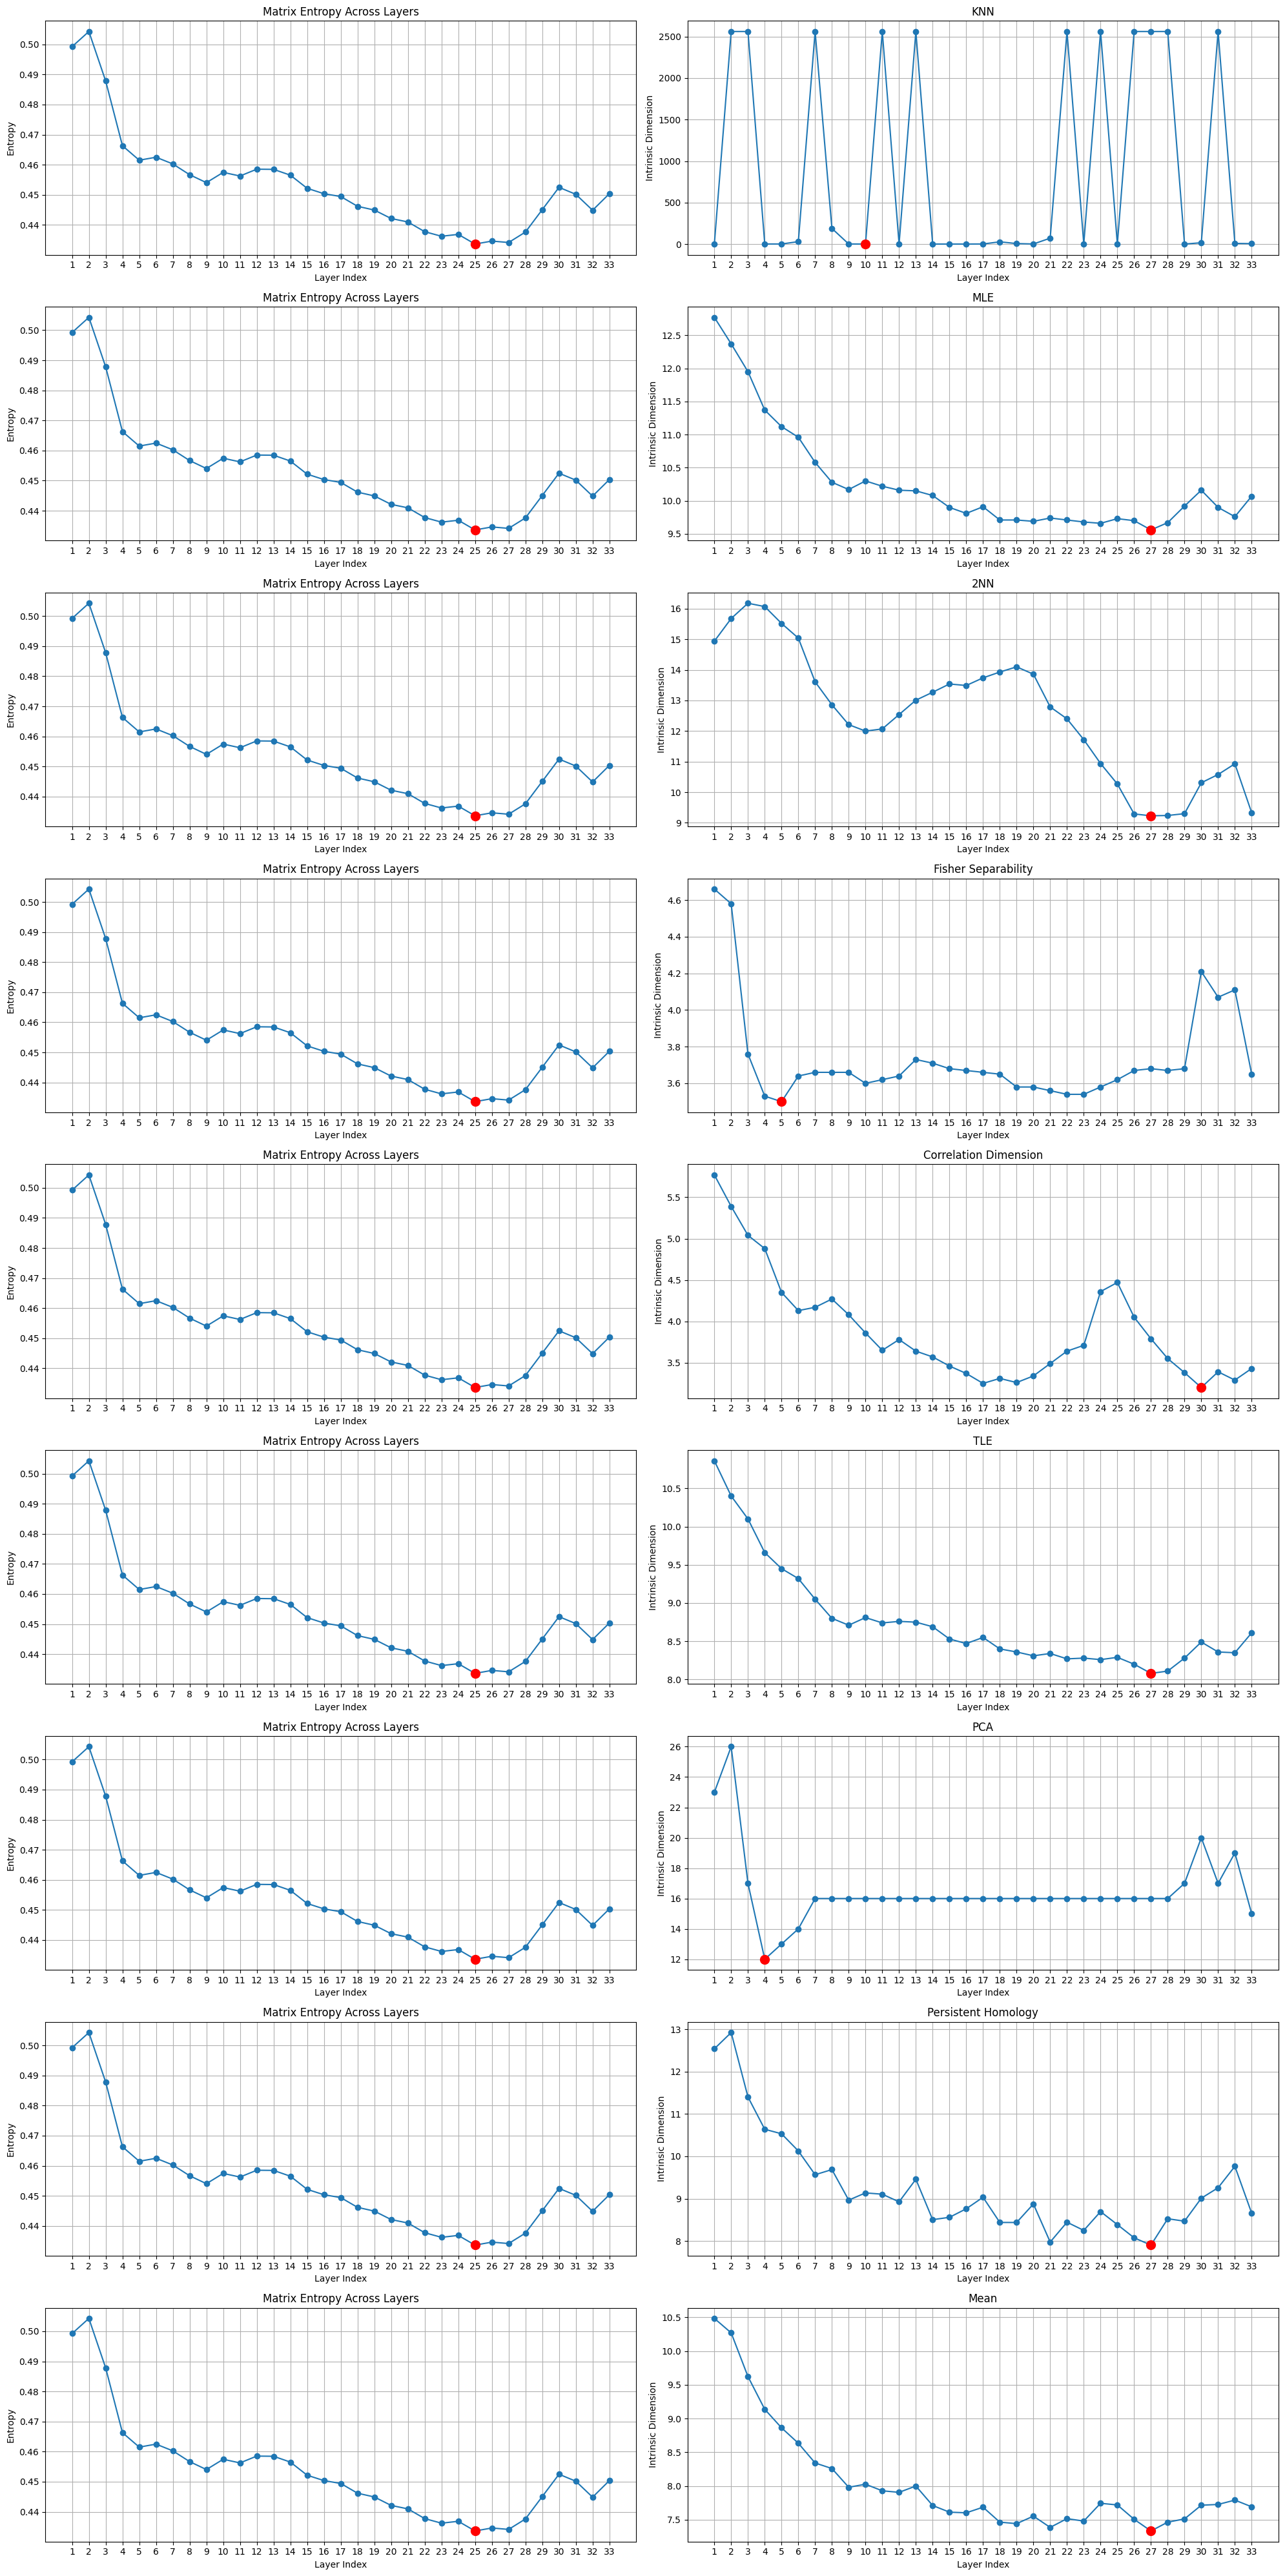

In [17]:
fig, axes = plt.subplots(9, 2, figsize=(20, 40))

# Titles for each subplot
titles = ["KNN", "MLE", "2NN", "Fisher Separability", "Correlation Dimension", "TLE", "PCA", "Persistent Homology", "Mean"]

# Data to plot
data = [id_knn, id_mle, id_2NN, id_fs, id_corrInt, id_tle, id_pca, id_persistent_homology, mean_id]
index = [min_index_3, min_index_4, min_index_5, min_index_7, min_index_8, min_index_9, min_index_10, min_index_11, min_index_12]


for i in range(9):
    axes[i, 0].plot(np.arange(1, len(entropy_list) + 1), entropy_list, marker='o', linestyle='-')
    axes[i, 0].plot(min_index_2, min(entropy_list), marker='o', color='red', markersize=10)
    axes[i, 0].set_title("Matrix Entropy Across Layers")
    axes[i, 0].set_xlabel('Layer Index')
    axes[i, 0].set_ylabel('Entropy')
    axes[i, 0].grid(True)
    axes[i, 0].set_xticks(np.arange(1, len(entropy_list) + 1))
    
    axes[i, 1].plot(np.arange(1, len(data[i]) + 1), data[i], marker='o', linestyle='-')
    axes[i, 1].plot(index[i], min(data[i]), marker='o', color='red', markersize=10)
    axes[i, 1].set_title(titles[i])
    axes[i, 1].set_xlabel('Layer Index')
    axes[i, 1].set_ylabel('Intrinsic Dimension')
    axes[i, 1].grid(True)
    axes[i, 1].set_xticks(np.arange(1, len(data[i]) + 1))

plt.tight_layout()
plt.savefig("intrinsic_dimensions.png")
plt.show()

In [ ]:
# Pearson’s correlation coefficient - strength of the linear relationship between two data samples.
# calculated by dividing the covariance of the two variables by the product of their respective standard deviations

In [22]:
titles = ["KNN", "MLE", "2NN", "Fisher Separability", "Correlation Dimension", "TLE", "PCA", "Persistent Homology", "Mean"]
data = [id_knn, id_mle, id_2NN, id_fs, id_corrInt, id_tle, id_pca, id_persistent_homology, mean_id]

In [23]:
from scipy.stats import pearsonr
# calculate Pearson's correlation
for d, title in zip(data,titles):
    corr, _ = pearsonr(entropy_list, d)
    print(f'Pearsons correlation for {title}: %.3f' % corr)

Pearsons correlation for KNN: 0.045
Pearsons correlation for MLE: 0.952
Pearsons correlation for 2NN: 0.678
Pearsons correlation for Fisher Separability: 0.640
Pearsons correlation for Correlation Dimension: 0.722
Pearsons correlation for TLE: 0.959
Pearsons correlation for PCA: 0.546
Pearsons correlation for Persistent Homology: 0.951
Pearsons correlation for Mean: 0.937


In [ ]:
# Persistent Homology for 4 runs - 0.896
# Persistent Homology for 10 runs - 0.933
# Persistent Homology for 20 runs - 0.951